## Load libraries

In [133]:
import pandas as pd # load and manipulate data
import numpy as np # calculation
import matplotlib.pyplot as plt # visualize data
from sklearn.preprocessing import OneHotEncoder # To one-hot encode variables
import category_encoders as ce # To target encode high cardinality variables
from datetime import datetime
# to build the model
import xgboost as xgb
from xgboost import XGBRegressor

## Load raw dataset

In [134]:
# Read the CSV file, ignoring the first column
demand = pd.read_csv('ecom_full_2024.csv', encoding='latin1', usecols=lambda column: column != 'Unnamed: 0')

In [135]:
### Ensure data privacy
import hashlib

def hash_value(value):
    return hashlib.sha256(value.encode()).hexdigest()

demand['product_name'] = demand['product_name'].apply(lambda x: hash_value(x))
demand['product_category'] = demand['product_category'].apply(lambda x: hash_value(x))
demand['brand'] = demand['brand'].apply(lambda x: hash_value(x))

print(demand)

             date   product_id  \
0        5/7/2024  10070408774   
1       5/12/2024  10070408774   
2       5/13/2024  10070408774   
3       5/20/2024  10070408774   
4       5/29/2024  10070408774   
5        5/4/2024  10269938769   
6       5/11/2024  10269938769   
7       5/24/2024  10269938769   
8       5/27/2024  10269938769   
9       5/28/2024  10269938769   
10      5/29/2024  10269938769   
11      7/18/2024  10269938769   
12       8/8/2024  10269938769   
13      8/19/2024  10269938769   
14      9/27/2024  10269938769   
15      10/1/2024  10269938769   
16     10/12/2024  10269938769   
17     10/25/2024  10269938769   
18     10/30/2024  10269938769   
19      11/8/2024  10269938769   
20     11/11/2024  10269938769   
21     11/13/2024  10269938769   
22     11/20/2024  10269938769   
23     11/26/2024  10269938769   
24      12/1/2024  10269938769   
25      12/5/2024  10269938769   
26       5/1/2024  10568187216   
27       5/2/2024  10568187216   
28       5/3/2

In [136]:
demand.to_csv('ecom_data.csv')

## Overview

In [137]:
print(demand.head().to_string())

        date   product_id                                                             brand                                                  product_category                                                      product_name  traffic  impressions  payment  revenue  product_ad_spend  shop_ad_spend  product_page_bounce_count  traffic_from_search  run_product_ad  run_shop_ad  conversion_rate  wm_yr_wk  wday  month   d  doubleday  near_dday  end_of_month  weekend  other_commercial_sale  day_offs  day_of_year  week_of_month  est_avg_price  avg_price  promotion_on  promotion_price price_bin  discount_rate  comment_received  product_rating  avg_category_comment  avg_category_rate  high_rating  high_comment  high_discount
0   5/7/2024  10070408774  4f691cf8af4335990a792962f5f7edeed916234dbe17b33054a626dd3c2f9346  f575e1ec32beef055e0bfcfe33625b06f92e89293878c834fd085d090572bd83  d4d37cfc4ac355ac93dffccc470e24051c3c0810f9306b09e9e70ae9d4edf422        1            1        0        0              

In [138]:
def check_unique_values(df):
    unique_values = {col: df[col].nunique() for col in df.columns}
    result_df = pd.DataFrame(list(unique_values.items()), columns=["Column Name", "Unique Value Count"])
    return result_df

check_unique_values(demand)

Column Name  Unique Value Count
0                        date                 245
1                  product_id                 135
2                       brand                  15
3            product_category                  21
4                product_name                 137
5                     traffic                  61
6                 impressions                 103
7                     payment                  14
8                     revenue                1287
9            product_ad_spend                 643
10              shop_ad_spend                   0
11  product_page_bounce_count                  22
12        traffic_from_search                  37
13             run_product_ad                   2
14                run_shop_ad                   1
15            conversion_rate                 128
16                   wm_yr_wk                  36
17                       wday                   7
18                      month                   8
19                          d                 245
20                  doubleday                   2
21                  near_dday                   2
22               end_of_month                   2
23                    weekend                   2
24      other_commercial_sale                   2
25                   day_offs                   2
26                day_of_year                 245
27              week_of_month                   6
28              est_avg_price                  70
29                  avg_price                  93
30               promotion_on                   2
31            promotion_price                  97
32                  price_bin                   4
33              discount_rate                  22
34           comment_received                  32
35             product_rating                   6
36       avg_category_comment                  12
37          avg_category_rate                   7
38                high_rating                   2
39               high_comment                   2
40              high_discount                   2

In [139]:
demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11822 entries, 0 to 11821
Data columns (total 41 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       11822 non-null  object 
 1   product_id                 11822 non-null  int64  
 2   brand                      11822 non-null  object 
 3   product_category           11822 non-null  object 
 4   product_name               11822 non-null  object 
 5   traffic                    11822 non-null  int64  
 6   impressions                11822 non-null  int64  
 7   payment                    11822 non-null  int64  
 8   revenue                    11822 non-null  int64  
 9   product_ad_spend           11822 non-null  int64  
 10  shop_ad_spend              0 non-null      float64
 11  product_page_bounce_count  11822 non-null  int64  
 12  traffic_from_search        11822 non-null  int64  
 13  run_product_ad             11822 non-null  int

Seems like we have some issues:
* Misalignment between `product_id` and `product_name`
* Some variables in the wrong data types

### Standardize data types

`date` should be in datetime data type

In [140]:
# Ensure the 'date' column is in datetime format
demand['date'] = pd.to_datetime(demand['date'])

# Sort the data by date, then product_id
demand = demand.sort_values(by=['product_id', 'date'])

`discount_rate` should be float   

`product_id` should be string

In [141]:
# Convert 'discount_rate' to float
# demand['discount_rate'] = pd.to_numeric(
#     demand['discount_rate'].str.replace('%', '', regex=False), 
#     errors='coerce'
# ).astype(float).round(4)

# Convert 'product_id' to string
demand['product_id'] = demand['product_id'].astype(str)

Double-check

In [142]:
demand.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11822 entries, 10059 to 10058
Data columns (total 41 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       11822 non-null  datetime64[ns]
 1   product_id                 11822 non-null  object        
 2   brand                      11822 non-null  object        
 3   product_category           11822 non-null  object        
 4   product_name               11822 non-null  object        
 5   traffic                    11822 non-null  int64         
 6   impressions                11822 non-null  int64         
 7   payment                    11822 non-null  int64         
 8   revenue                    11822 non-null  int64         
 9   product_ad_spend           11822 non-null  int64         
 10  shop_ad_spend              0 non-null      float64       
 11  product_page_bounce_count  11822 non-null  int64         
 12  traff

In [143]:
print(demand.head().to_string())

            date  product_id                                                             brand                                                  product_category                                                      product_name  traffic  impressions  payment  revenue  product_ad_spend  shop_ad_spend  product_page_bounce_count  traffic_from_search  run_product_ad  run_shop_ad  conversion_rate  wm_yr_wk  wday  month   d  doubleday  near_dday  end_of_month  weekend  other_commercial_sale  day_offs  day_of_year  week_of_month  est_avg_price  avg_price  promotion_on  promotion_price price_bin  discount_rate  comment_received  product_rating  avg_category_comment  avg_category_rate  high_rating  high_comment  high_discount
10059 2024-05-29  3388329772  0c11971ede300e8f8c3b1ce00d14d47474c4ef0206a9fd9532bbb462ab06916b  a44f96f2ae1f169df61a6ca60bda9010eeb3d754eaff98291d89a7d486a46905  daf0922f6e714b93bd032ed7e492460840f1e0a580823d214f578a52ab795b42        1            1        0        0        

### Fix misalignment between `product_id` and `product_name`

In [144]:
def check_row_misalignment(df, col1, col2):
    misaligned = df.groupby(col1)[col2].nunique().reset_index()
    misaligned = misaligned[misaligned[col2] > 1]
    return misaligned

misaligned_rows = check_row_misalignment(demand, 'product_id', 'product_name')
print(misaligned_rows)

misaligned_product_ids = misaligned_rows['product_id'].tolist()

print("Check these product_ids for misalignment between product_id and product_name:")
print(misaligned_product_ids)

     product_id  product_name
43  15765129329             2
78  21382736254             2
83  22150796991             2
Check these product_ids for misalignment between product_id and product_name:
['15765129329', '21382736254', '22150796991']


In [145]:
# # I check it manually with excel to investigate, if you want to see for yourself, you can uncomment these lines

# filtered_by_product_id = demand[demand['product_id'].isin(misaligned_product_ids)]

# # Check the shape of the DataFrame
# rows, columns = filtered_by_product_id.shape

# print(f"Number of rows: {rows}")
# print(f"Number of columns: {columns}")

# # Export data to check in excel
# filtered_by_product_id.to_csv('filtered_by_product_id.csv')

I examined the data and see that there are dates where `product_name` A in `product_id` 1 had data. Within that same date, `product_name` B corresponding to the same `product_id` has 0 for its variables. And vice versa. So I'll keep rows where the `product_id` has "meaningful data" (non-zero values for its important variables), and eliminate rows where the `product_id` carries 0 for its variables (impressions, traffic, etc.) in another `product_name` for the same `date`.

This is because in the last week of November, the sales admin changed the content of the product pages: keeping high performing `product_id` (meaning the `product_id` contains high rating, high comment volumes, etc), merging low performing products into that `product_id` and then changed the name of the corresponding `product_name`.

In [146]:
# Filter the DataFrame for misaligned product_ids
filtered_demand = demand[demand['product_id'].isin(misaligned_product_ids)]

# Case 1: Remove duplicate rows based on the specified subset of columns
filtered_demand = filtered_demand.drop_duplicates(subset=['date', 'product_id', 'traffic', 'impressions', 'payment'])

# Case 2: After Case 1, check for each combination of date & product_id, if there are 2 rows,
# keep the row with impressions > 0 or payment > 0, else remove the row with impressions = 0.
def filter_impressions_and_payment(group):
    if len(group) == 2:  # Ensure there are exactly 2 rows per combination
        # Check for rows where impressions = 0 and the other row has either impressions > 0 or payment > 0
        if (group['impressions'] == 0).any() and ((group['impressions'] > 0).any() or (group['payment'] > 0).any()):
            # Keep the row where impressions > 0 or payment > 0
            group = group[(group['impressions'] > 0) | (group['payment'] > 0)]
    return group

# Apply the filtering logic only to the filtered DataFrame
filtered_demand = filtered_demand.groupby(['date', 'product_id'], group_keys=False).apply(filter_impressions_and_payment)

C:\Users\ngtran\AppData\Local\Temp\ipykernel_5408\3250136266.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_demand = filtered_demand.groupby(['date', 'product_id'], group_keys=False).apply(filter_impressions_and_payment)


In [147]:
# Group by 'product_id' and count the number of rows for each
date_counts = filtered_demand.groupby('product_id')['date'].count()

# Set display option to show all rows
pd.set_option('display.max_rows', None)
# pd.reset_option('display.max_rows')

# Print the total counts for each product_id
print("Total rows (all dates) for each product_id:")
print(date_counts)

Total rows (all dates) for each product_id:
product_id
15765129329    122
21382736254    230
22150796991    230
Name: date, dtype: int64


It's aligned now.

In [148]:
# Update the original DataFrame with the modified rows for misaligned product_ids
# First, drop the rows for the misaligned product_ids from the original DataFrame
demand = demand[~demand['product_id'].isin(misaligned_product_ids)]

# Then, append the filtered DataFrame back
demand = pd.concat([demand, filtered_demand], ignore_index=True)

## Feature engineering

### Ensure order of `date` for each `product_id`
Sorting will be applied first by `product_id` and then by `date`for creating lagging, and rolling features later

In [149]:
# Sort the data by product_id and date
demand = demand.sort_values(by=['product_id', 'date'])

demand.head()

date   product_id  \
1763 2024-05-07  10070408774   
1764 2024-05-12  10070408774   
1765 2024-05-13  10070408774   
1766 2024-05-20  10070408774   
1767 2024-05-29  10070408774   

                                                  brand  \
1763  4f691cf8af4335990a792962f5f7edeed916234dbe17b3...   
1764  4f691cf8af4335990a792962f5f7edeed916234dbe17b3...   
1765  4f691cf8af4335990a792962f5f7edeed916234dbe17b3...   
1766  4f691cf8af4335990a792962f5f7edeed916234dbe17b3...   
1767  4f691cf8af4335990a792962f5f7edeed916234dbe17b3...   

                                       product_category  \
1763  f575e1ec32beef055e0bfcfe33625b06f92e89293878c8...   
1764  f575e1ec32beef055e0bfcfe33625b06f92e89293878c8...   
1765  f575e1ec32beef055e0bfcfe33625b06f92e89293878c8...   
1766  f575e1ec32beef055e0bfcfe33625b06f92e89293878c8...   
1767  f575e1ec32beef055e0bfcfe33625b06f92e89293878c8...   

                                           product_name  traffic  impressions  \
1763  d4d37cfc4ac355ac93dffccc470e24051c3c0810f9306b...        1            1   
1764  d4d37cfc4ac355ac93dffccc470e24051c3c0810f9306b...        2            2   
1765  d4d37cfc4ac355ac93dffccc470e24051c3c0810f9306b...        1            1   
1766  d4d37cfc4ac355ac93dffccc470e24051c3c0810f9306b...        1            1   
1767  d4d37cfc4ac355ac93dffccc470e24051c3c0810f9306b...        1            1   

      payment  revenue  product_ad_spend  ...  promotion_price  price_bin  \
1763        0        0                 0  ...         237600.0      cheap   
1764        0        0                 0  ...         237600.0      cheap   
1765        0        0                 0  ...         237600.0      cheap   
1766        0        0                 0  ...         237600.0      cheap   
1767        0        0                 0  ...         237600.0      cheap   

      discount_rate  comment_received  product_rating  avg_category_comment  \
1763            NaN               NaN             NaN              7.666667   
1764            NaN               NaN             NaN              7.666667   
1765            NaN               NaN             NaN              7.666667   
1766            NaN               NaN             NaN              7.666667   
1767            NaN               NaN             NaN              7.666667   

      avg_category_rate  high_rating  high_comment  high_discount  
1763           4.886667            0             0              0  
1764           4.886667            0             0              0  
1765           4.886667            0             0              0  
1766           4.886667            0             0              0  
1767           4.886667            0             0              0  

[5 rows x 41 columns]

### sine/cosine transforms time variables to capture periodicity and cyclic patterns

In [150]:
# For cyclical encoding, use sine/cosine transforms
def cyclical_encode(series, max_val):
    # series are values from 1 to max_val
    # Convert to 0-based: (value-1)
    sine = np.sin(2 * np.pi * (series - 1) / max_val)
    cosine = np.cos(2 * np.pi * (series - 1) / max_val)
    return sine, cosine

# Cyclical encode weekday (7 days in a week)
demand['wday_sin'], demand['wday_cos'] = cyclical_encode(demand['wday'], 7)
# Cyclical encode month (12 months)
demand['month_sin'], demand['month_cos'] = cyclical_encode(demand['month'], 12)
# Cyclical encode week_of_the_month (assume up to 5 weeks in a month)
demand['wom_sin'], demand['wom_cos'] = cyclical_encode(demand['week_of_month'], 5)
# Cyclical encode day_of_year (assume up to 365 days in a year)
demand['day_of_year_sin'], demand['day_of_year_cos'] = cyclical_encode(demand['day_of_year'], 365)

### Lag and rolling features for important numeric columns
How I defined 'important' is based on domain knowledge and intuition first, then we can refine features later

In [151]:
# Define the columns to create the features on
numeric_cols = ['payment', 'revenue', 'product_ad_spend', 'shop_ad_spend']

# Create lag features (e.g., lag_1, lag_3, lag_7, lag_14, lag_28)
lag_periods = [3, 28]
for col in numeric_cols:
    if col in demand.columns:
        for lag in lag_periods:
            demand[f'{col}_lag_{lag}'] = demand.groupby('product_id')[col].shift(lag) #Reset lagging for every product_id

### Create rolling features (example: 7-day rolling mean)

In [152]:
# Define the columns to create the features on
numeric_cols = ['traffic', 'impressions', 'payment', 'revenue', 'product_ad_spend', 'shop_ad_spend']

rolling_windows = [7, 28]  # Define the rolling windows
for rolling_window in rolling_windows:
    for col in numeric_cols:  # Ensure these are the numeric columns you want to apply rolling features to
        if col in demand.columns:
            demand[f'{col}_rolling_{rolling_window}d_mean'] = (
                demand.groupby('product_id')[col] #Reset rolling for every product_id
                .transform(lambda x: x.shift(1).rolling(rolling_window).mean())
            )

### Category-level average within each month and each week
* There are homogenous patterns for each `product_category` (reference 'M5 Competition'), so we need to extract category-level data for the model to enhance learning process.
* Besides, in execution, it is easier to manage on category level, not on every single product level. So if we can learn anything helpful, we can apply into our category growth plan.

In [153]:
if 'product_category' in demand.columns:
    # Daily aggregation
    cat_rev = demand.groupby(['product_category', 'date'])['product_ad_spend'].mean().reset_index(name='cat_daily_avg_product_ad_spend')
    cat_traffic = demand.groupby(['product_category', 'date'])['traffic'].mean().reset_index(name='cat_daily_avg_traffic')

    # Monthly aggregation
    cat_month_rev = demand.groupby(['product_category', 'month'])['product_ad_spend'].mean().reset_index(name='cat_month_avg_product_ad_spend')
    cat_month_traffic = demand.groupby(['product_category', 'month'])['traffic'].mean().reset_index(name='cat_month_avg_traffic')

    # Weekly aggregation (assuming 'week_of_month' corresponds to the day of the week)
    cat_week_rev = demand.groupby(['product_category', 'week_of_month'])['product_ad_spend'].mean().reset_index(name='cat_week_avg_product_ad_spend')
    cat_week_traffic = demand.groupby(['product_category', 'week_of_month'])['traffic'].mean().reset_index(name='cat_week_avg_traffic')

    # Merging daily aggregated values back to the main dataframe
    demand = pd.merge(demand, cat_rev, on=['product_category', 'date'], how='left')
    demand = pd.merge(demand, cat_traffic, on=['product_category', 'date'], how='left')

    # Merging monthly aggregated values
    demand = pd.merge(demand, cat_month_rev, on=['product_category', 'month'], how='left')
    demand = pd.merge(demand, cat_month_traffic, on=['product_category', 'month'], how='left')

    # Merging weekly aggregated values
    demand = pd.merge(demand, cat_week_rev, on=['product_category', 'week_of_month'], how='left')
    demand = pd.merge(demand, cat_week_traffic, on=['product_category', 'week_of_month'], how='left')

#### Continuous zero-sale days until today
I learned about `continuous_zero_sales_days` from the repetitive feature engineering practices in the M5 competition. I believe this feature is highly effective in helping the model understand sporadic sales patterns for certain `product_id`s and `product_category`s.

Lag `continuous_zero_sales_days` by 1 day to avoid data leakage.

In [154]:
demand = demand.sort_values(by=['product_id', 'date'])

def continuous_zero_sales(group):
    zero_sales_days = (group['payment'] == 0).astype(int)  # 1 if no sale that day, else 0
    # This cumsum + groupby trick counts consecutive runs of 1s
    return zero_sales_days.groupby((zero_sales_days != zero_sales_days.shift()).cumsum()).cumsum()

demand['continuous_zero_sales_days'] = (
    demand.groupby('product_id', group_keys=False).apply(continuous_zero_sales)
)

# Shift the result by 1 day within each `product_id`` to avoid data leakage
demand['continuous_zero_sales_days'] = (
    demand.groupby('product_id')['continuous_zero_sales_days']
          .shift(1)
)

C:\Users\ngtran\AppData\Local\Temp\ipykernel_5408\179599327.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  demand.groupby('product_id', group_keys=False).apply(continuous_zero_sales)


Since this feature is important, to create lagging and rolling features for it is not a bad idea, I reckon

In [155]:
# Rolling features for `continuous_zero_sales_days` on product_id level
# Rolling window of 14 days is based on domain knowledge and reviewing the dataset
rolling_window = 14
demand['zero_sales_rolling_mean_14d'] = (
    demand.groupby('product_id')['continuous_zero_sales_days']
          .transform(lambda x: x.rolling(rolling_window, min_periods=1).mean())
)
demand['zero_sales_rolling_max_14d'] = (
    demand.groupby('product_id')['continuous_zero_sales_days']
          .transform(lambda x: x.rolling(rolling_window, min_periods=1).max())
)

In [156]:
# Category level zero_sales_rolling_mean_14d
# Compute category-level average of zero_sales_rolling_mean_14d
cat_rolling_avg_zero_sales_14d = (
    demand.groupby(['product_category', 'date'])['zero_sales_rolling_mean_14d']
          .mean()
          .reset_index()
          .rename(columns={'zero_sales_rolling_mean_14d': 'cat_rolling_avg_zero_sales_14d'})
)

# Merge back to the original DataFrame
demand = pd.merge(demand, cat_rolling_avg_zero_sales_14d, on=['product_category', 'date'], how='left')

In [157]:
# Interaction between category-level rolling zero sales and promotion
demand['cat_zero_sales_x_promotion'] = (
    demand['cat_rolling_avg_zero_sales_14d'] * demand['promotion_on']
)

In [158]:
# Step 0: Ensure data is sorted by 'product_category' and 'date'
demand = demand.sort_values(by=['product_category', 'date'])

# Trend in rolling average of `continuous_zero_sales_days`
# Step 1.1: Compute category-level trend of zero_sales_rolling_mean_14d
# Ensure it considers time order properly
cat_trend = (
    demand.groupby(['product_category', 'date'])['cat_rolling_avg_zero_sales_14d']
          .mean()  # Aggregate for consistent value per 'product_category' and 'date'
          .groupby(level=0)  # Group again by 'product_category'
          .transform(lambda x: x.diff(14))  # Calculate 14-day trend
          .reset_index(name='cat_rolling_avg_zero_sales_trend_14d')  # Create a new DataFrame
)

# Step 1.2: Merge back to the original DataFrame on 'product_category' and 'date'
demand = pd.merge(demand, cat_trend, on=['product_category', 'date'], how='left')

# Percentage changes in rolling average of `continuous_zero_sales_days`
# Step 2.1: Compute category-level trend of zero_sales_rolling_mean_14d
# Ensure it considers time order properly
cat_pect_trend = (
    demand.groupby(['product_category', 'date'])['cat_rolling_avg_zero_sales_14d']
          .mean()  # Aggregate for consistent value per 'product_category' and 'date'
          .groupby(level=0)  # Group again by 'product_category'
          .transform(lambda x: x.pct_change(14))  # Calculate 14-day trend
          .reset_index(name='cat_rolling_avg_zero_sales_pct_change_14d')  # Create a new DataFrame
)

# Step 2.2: Merge back to the original DataFrame on 'product_category' and 'date'
demand = pd.merge(demand, cat_pect_trend, on=['product_category', 'date'], how='left')

C:\Users\ngtran\AppData\Local\Temp\ipykernel_5408\3774401002.py:25: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .transform(lambda x: x.pct_change(14))  # Calculate 14-day trend


In [159]:
# Sort data to ensure it is in time order
demand = demand.sort_values(by=['date', 'product_id'])

# Lagged values of category-level zero sales rolling average
for lag in [7, 14, 28]:
    demand[f'cat_rolling_avg_zero_sales_lag_{lag}d'] = (
        demand.groupby('product_id')['cat_rolling_avg_zero_sales_14d']
              .transform(lambda x: x.shift(lag))
    )

## Normalized price-related variables:
* Scale: category level

In [160]:
# Step 1: Group by 'product_category' and calculate mean and std for 'avg_price' and 'promotion_price'
category_stats = demand.groupby('product_category').agg(
    avg_price_mean=('avg_price', 'mean'),
    avg_price_std=('avg_price', 'std'),
    promotion_price_mean=('promotion_price', 'mean'),
    promotion_price_std=('promotion_price', 'std')
).reset_index()

# Step 2: Merge these statistics back to the original DataFrame
demand = pd.merge(demand, category_stats, on='product_category', how='left')

# Step 3: Create normalized columns
demand['normalized_avg_price'] = (demand['avg_price'] - demand['avg_price_mean']) / demand['avg_price_std']
demand['normalized_promotion_price'] = (demand['promotion_price'] - demand['promotion_price_mean']) / demand['promotion_price_std']

# Dropping unnecessary intermediate columns for cleanliness (optional)
demand = demand.drop(columns=['avg_price_mean', 'avg_price_std', 'promotion_price_mean', 'promotion_price_std'])

### Features based on domain knowledge

In [161]:
# Ad spend during promotion, weekend
if 'promotion_on' in demand.columns and 'product_ad_spend' in demand.columns:
    demand['ad_spend_during_promotion'] = demand['product_ad_spend'] * demand['promotion_on']

if 'weekend' in demand.columns and 'product_ad_spend' in demand.columns:
    demand['weekend_ad_spend'] = demand['weekend'] * demand['product_ad_spend']

In [162]:
# CTR
if 'traffic' in demand.columns and 'impressions' in demand.columns:
    demand['CTR'] = np.where(demand['impressions'] == 0, 0, demand['traffic'] / demand['impressions'])

### Last steps
## One-hot encoding

In [163]:
# Identify categorical features for one-hot encoding
cat_cols = []
for col in ['product_category', 'brand', 'price_bin']:
    if col in demand.columns and demand[col].dtype == 'object':
        cat_cols.append(col)

# Perform one-hot encoding
if cat_cols:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # Use sparse_output instead of sparse
    # Fit-transform
    ohe_data = ohe.fit_transform(demand[cat_cols])
    # Create a DataFrame with OHE results
    ohe_df = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(cat_cols), index=demand.index)
    # Concatenate back
    demand = pd.concat([demand.drop(cat_cols, axis=1), ohe_df], axis=1)

Due to the high cardinality of `product_id`, one-hot encoding is not a suitable approach.

So I'll try target encoding on it.

## Target encoding: product_id

In [164]:
#Instantiate a target encoder
te = ce.TargetEncoder(cols=['product_id'])

# Fit the encoder on the training set
demand['product_id_target_enc'] = te.fit_transform(demand['product_id'], demand['payment'])

# Drop original if desired
demand.drop('product_id', axis=1, inplace=True)

## Modeling

### Define features and target

In [165]:
# Review all variables
demand.columns.tolist()

['date',
 'product_name',
 'traffic',
 'impressions',
 'payment',
 'revenue',
 'product_ad_spend',
 'shop_ad_spend',
 'product_page_bounce_count',
 'traffic_from_search',
 'run_product_ad',
 'run_shop_ad',
 'conversion_rate',
 'wm_yr_wk',
 'wday',
 'month',
 'd',
 'doubleday',
 'near_dday',
 'end_of_month',
 'weekend',
 'other_commercial_sale',
 'day_offs',
 'day_of_year',
 'week_of_month',
 'est_avg_price',
 'avg_price',
 'promotion_on',
 'promotion_price',
 'discount_rate',
 'comment_received',
 'product_rating',
 'avg_category_comment',
 'avg_category_rate',
 'high_rating',
 'high_comment',
 'high_discount',
 'wday_sin',
 'wday_cos',
 'month_sin',
 'month_cos',
 'wom_sin',
 'wom_cos',
 'day_of_year_sin',
 'day_of_year_cos',
 'payment_lag_3',
 'payment_lag_28',
 'revenue_lag_3',
 'revenue_lag_28',
 'product_ad_spend_lag_3',
 'product_ad_spend_lag_28',
 'shop_ad_spend_lag_3',
 'shop_ad_spend_lag_28',
 'traffic_rolling_7d_mean',
 'impressions_rolling_7d_mean',
 'payment_rolling_7d_mean

#### Exclude some variables out of features used for training:
* Prevent data leakage: Ensure that information unavailable at prediction time is not included in the training process.
* Avoid duplication: Eliminate redundant features that may skew the model's learning.
* Align with learning objectives: Select features based on the specific goals of the model.

In [166]:
exclude_cols = ['date', 'product_name', 'conversion_rate', 'payment', 'revenue_rolling_28d_mean', 'revenue_rolling_7d_mean', 'revenue_lag_28', 'revenue_lag_3', 'd', 'revenue']  # Adjust as needed
features = [col for col in demand.columns if col not in exclude_cols]
target = 'payment'

## Cross-validation
Train on historical data up to some month, validate on the next month.
* To fine-tune model hyperparameters
* To see stability in RMSE score through each folds to see if the model is stable across months, meaning the model generalizes well.

In [167]:
# Helper function for creating CV folds while reserving time order
def split_by_month(df, train_end_month, val_month, features, target):
    train_end = pd.to_datetime(train_end_month + '-01') + pd.offsets.MonthEnd(1)
    val_start = pd.to_datetime(val_month + '-01')
    val_end = val_start + pd.offsets.MonthEnd(1)

    train_df = df[df['date'] <= train_end]
    val_df = df[(df['date'] >= val_start) & (df['date'] <= val_end)]

    X_train = train_df[features]
    y_train = train_df[target]
    X_val = val_df[features]
    y_val = val_df[target]

    # Create sample weights for training data to boost doubleday
    sample_weights = np.where(X_train['doubleday'] == 1, 10.0, 1.0)

    return X_train, y_train, X_val, y_val, sample_weights

# ---- TIME-BASED CROSS-VALIDATION ----

train_end_month_list = ['2024-07', '2024-08', '2024-09', '2024-10', '2024-11']
val_month_list       = ['2024-08', '2024-09', '2024-10', '2024-11', '2024-12']

cv_rmse_scores = []

for train_end, val_month in zip(train_end_month_list, val_month_list):
    X_train, y_train, X_val, y_val, sample_weights = split_by_month(demand, train_end, val_month, features, target)

    # Convert to numeric/categorical/bool only, if needed
    X_train = X_train.select_dtypes(include=[np.number, 'category', 'bool'])
    X_val = X_val.select_dtypes(include=[np.number, 'category', 'bool'])

    dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights)
    dval = xgb.DMatrix(X_val, label=y_val)

    params = {
        'booster': 'gbtree',
        #'n_estimators': 1000,
        #'early_stopping_rounds': 60,
        'objective': 'reg:squarederror',
        'learning_rate': 0.01,
        'max_depth': 3
    }

    # Training
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=1000,
        evals=[(dval, 'eval')],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    val_preds = model.predict(dval)
    val_rmse = np.sqrt(np.mean((y_val - val_preds)**2))
    cv_rmse_scores.append(val_rmse)

    print(f"Train End: {train_end}, Validation Month: {val_month}, RMSE: {val_rmse:.3f}")

avg_rmse = np.mean(cv_rmse_scores)
print(f"\nTime-based CV Average RMSE: {avg_rmse:.3f}")

Train End: 2024-07, Validation Month: 2024-08, RMSE: 0.592
Train End: 2024-08, Validation Month: 2024-09, RMSE: 0.535
Train End: 2024-09, Validation Month: 2024-10, RMSE: 0.536
Train End: 2024-10, Validation Month: 2024-11, RMSE: 0.538
Train End: 2024-11, Validation Month: 2024-12, RMSE: 0.645

Time-based CV Average RMSE: 0.569


Since these hyperparameters:

``` 
params = {
        'booster': 'gbtree',
        'objective': 'reg:squarederror',
        'learning_rate': 0.01,
        'max_depth': 3
    }
```

yield the smallest `average RMSE`: 0.569. I will use this set-up to build the final model with all the data.

## Final model

In [168]:
# Train up to '2024-11-30', then validate the model based on December data.
train_end_date = pd.to_datetime('2024-11-30') 
test_start_date = pd.to_datetime('2024-12-01') 
test_end_date = pd.to_datetime('2024-12-31')  

# 1) Split the data
train_df = demand[demand['date'] <= train_end_date]
test_df  = demand[(demand['date'] >= test_start_date) & (demand['date'] <= test_end_date)]

# 2) Create training/test sets
X_train = train_df[features]
y_train = train_df[target]
X_test  = test_df[features]
y_test  = test_df[target]

# 3) Create sample weights for training
sample_weights = np.where(X_train['doubleday'] == 1, 10.0, 1.0)

# 4) Convert to numeric/categorical/bool as needed 
X_train = X_train.select_dtypes(include=[np.number, 'category', 'bool'])
X_test  = X_test.select_dtypes(include=[np.number, 'category', 'bool'])

# 5) Create DMatrices
dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights)
dtest  = xgb.DMatrix(X_test, label=y_test)

# 6) Use the same hyperparameters from cross-validation training
final_params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'learning_rate': 0.01,
    'max_depth': 3
}

# 7) Train final model
final_model = xgb.train(
    params=final_params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=[(dtest, 'eval')], 
    early_stopping_rounds=50,
    verbose_eval=True
)

# 8) Generate predictions on December 2024
test_preds = final_model.predict(dtest)

# 9) Compute RMSE
final_rmse = np.sqrt(np.mean((y_test - test_preds) ** 2))
print(f"Final Test RMSE (Dec 2024): {final_rmse:.3f}")

[0]	eval-rmse:1.14081
[1]	eval-rmse:1.13612
[2]	eval-rmse:1.13151
[3]	eval-rmse:1.12696
[4]	eval-rmse:1.12247
[5]	eval-rmse:1.11805
[6]	eval-rmse:1.11369
[7]	eval-rmse:1.10940
[8]	eval-rmse:1.10516
[9]	eval-rmse:1.10099
[10]	eval-rmse:1.09656
[11]	eval-rmse:1.09195
[12]	eval-rmse:1.08773
[13]	eval-rmse:1.08347
[14]	eval-rmse:1.07935
[15]	eval-rmse:1.07530
[16]	eval-rmse:1.07013
[17]	eval-rmse:1.06500
[18]	eval-rmse:1.05996
[19]	eval-rmse:1.05581
[20]	eval-rmse:1.05172
[21]	eval-rmse:1.04686
[22]	eval-rmse:1.04283
[23]	eval-rmse:1.03790
[24]	eval-rmse:1.03412
[25]	eval-rmse:1.02956
[26]	eval-rmse:1.02577
[27]	eval-rmse:1.02239
[28]	eval-rmse:1.01867
[29]	eval-rmse:1.01540
[30]	eval-rmse:1.01181
[31]	eval-rmse:1.00759
[32]	eval-rmse:1.00406
[33]	eval-rmse:0.99990
[34]	eval-rmse:0.99656
[35]	eval-rmse:0.99359
[36]	eval-rmse:0.98944
[37]	eval-rmse:0.98614
[38]	eval-rmse:0.98241
[39]	eval-rmse:0.97945
[40]	eval-rmse:0.97641
[41]	eval-rmse:0.97282
[42]	eval-rmse:0.97002
[43]	eval-rmse:0.9663

## Plot Prediction vs. Actual

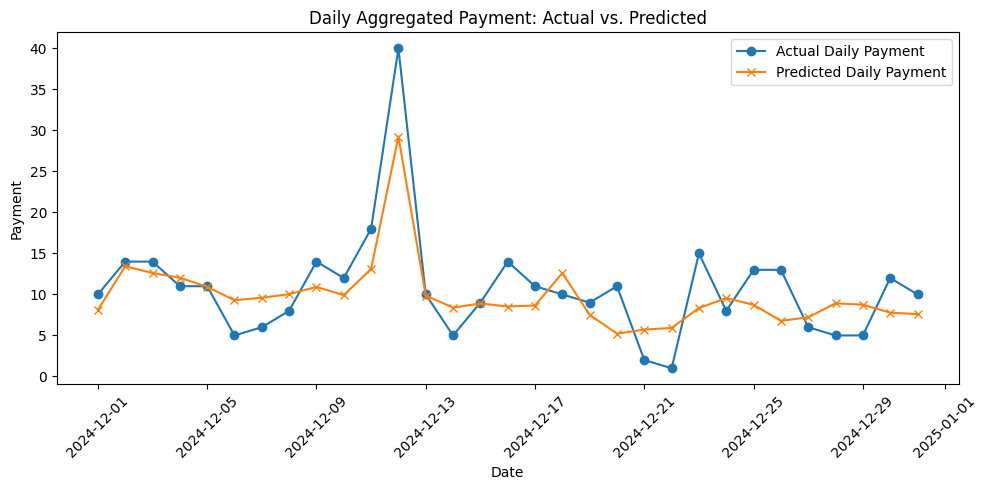

In [169]:
val_df = demand[(demand['date'] >= '2024-12-01') & (demand['date'] <= '2024-12-31')].copy()

# Ensure val_df is sorted by date for a proper line plot
val_df.sort_values(by='date', inplace=True)

val_df['predicted_payment'] = test_preds

# 1) Aggregate payments by date
daily_agg = (
    val_df
    .groupby('date', as_index=False)
    .agg({'payment': 'sum', 'predicted_payment': 'sum'})
    .rename(columns={
        'payment': 'actual_daily_payment',
        'predicted_payment': 'predicted_daily_payment'
    })
)

# 2) Ensure chronological order
daily_agg.sort_values('date', inplace=True)

# 3) Plot both series on the same line chart
plt.figure(figsize=(10, 5))
plt.plot(daily_agg['date'], daily_agg['actual_daily_payment'], marker='o', label='Actual Daily Payment')
plt.plot(daily_agg['date'], daily_agg['predicted_daily_payment'], marker='x', label='Predicted Daily Payment')
plt.xlabel('Date')
plt.ylabel('Payment')
plt.title('Daily Aggregated Payment: Actual vs. Predicted')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Feature Importance

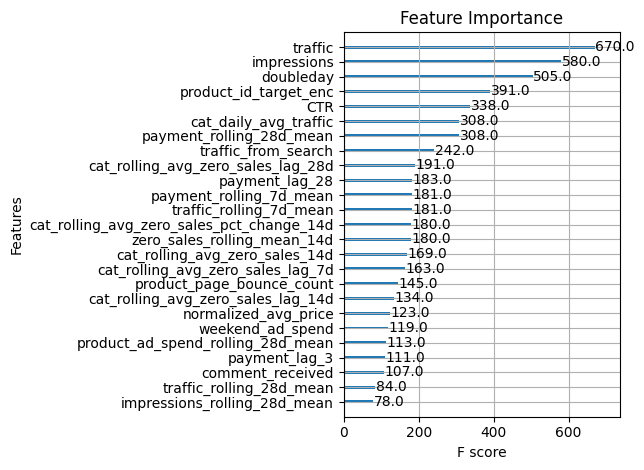

In [170]:
xgb.plot_importance(model, max_num_features=25)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

### Save the model to a file

In [171]:
model.save_model('ecom_pred_xgboost_model.json')

# Later, you can load it back like this:
# loaded_model = xgb.Booster()
# loaded_model.load_model('xgboost_model.json')

## Predict unknown date: Jan 2025
TBU